<a href="https://colab.research.google.com/github/jasondupree/jasondupree.github.io/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook Preparation**

## Import Libraries

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score, accuracy_score, auc, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy

import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Suppress ConvergenceWarning for this context
warnings.simplefilter('ignore', ConvergenceWarning)

## Mount Drive and Update Display

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

pd.set_option('display.max_columns', None)  # Ensures all columns are displayed
pd.set_option('display.width', None)        # Utilizes the maximum width of your display

from IPython.display import display, HTML

Mounted at /content/drive/


## Import Data

In [12]:
file_path = '/content/drive/My Drive/Data Science Courses/Colab Notebooks/Machine Learning/Projects/HW4/fashion_mnist.p'
# Load the data from the pickle file
with open(file_path, 'rb') as file:
    train_images, test_images, train_labels, test_labels = pickle.load(file)

# Used OpenAI to write the code below.
# Assuming images are stored as flattened arrays, let's check the shape of the first image
first_image_shape = train_images[0].shape
print("Shape of the first training image:", first_image_shape)

# Calculate n as the product of the dimensions of the image if it's flattened
n = np.prod(first_image_shape)
print("Number of input features, n:", n)

Shape of the first training image: (784,)
Number of input features, n: 784


# **Summary**

Fashion MNIST
In class, we have been using the famous MNIST dataset of hand-written digits. Fashion
MNIST is another famous dataset of images with many similarities to MNIST:
• Each image is 28-by-28 pixels in grayscale
• Each image belongs to one of 10 categories
• There are 60,000 training samples, and 10,000 test samples
One consequence of these similarities is that you can in fact run the coding demos from lectures on this dataset without changing anything (except of course switching the name of the input file to fashion mnist.p) when loading the dataset into memory.

## The difference is that the images in Fashion MNIST represent clothing items rather than digits:


| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

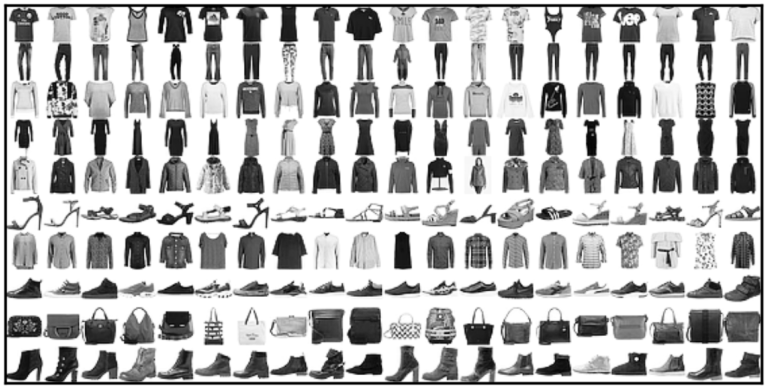

# **6.1: Neural Networks without Convolution**

## 6.1(a): Consider a neural network consisting of a linear layer with 128 nodes, followed by a ReLU layer, followed by a linear layer with 10 nodes. How many parameters (that need to be trained) does this neural network have?

In [15]:
# Research
# https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
# https://saturncloud.io/blog/check-the-total-number-of-parameters-in-a-pytorch-model/
# https://chat.openai.com/c/564de56e-3e3f-40a5-a001-c119738f7873
# https://learn.flucoma.org/learn/mlp-parameters/
# https://medium.com/@al.lucas.thesauce/creating-a-pytorch-neural-network-with-chatgpt-d6eefffab467

# Number of input features
n = 784

# Parameters in the first linear layer
params_first_layer = (n * 128) + 128

# Parameters in the second linear layer
params_second_layer = (128 * 10) + 10

# Total parameters
total_params = params_first_layer + params_second_layer

print("Total trainable parameters in the neural network:", total_params)

Total trainable parameters in the neural network: 101770


## 6.1(b): Train this neural network. Report the in-sample cross-entropy, and out-of-sample accuracy. (You can stop the training process when you feel it has “converged”)

In [19]:
# Research
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
# https://medium.com/@al.lucas.thesauce/creating-a-pytorch-neural-network-with-chatgpt-d6eefffab467

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # First linear layer
        self.relu = nn.ReLU()           # ReLU layer
        self.fc2 = nn.Linear(128, 10)   # Second linear layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network and optimizer
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Parameters
patience = 5
patience_counter = 0
best_val_loss = float('inf')

# Training the network with early stopping
def train_model(model, train_loader, test_loader):
    global best_val_loss  # Declare as global to modify the variable inside this function
    global patience_counter  # Declare as global to modify the variable inside this function
    for epoch in range(50):  # set a large enough number to allow for early stopping
        model.train()
        total_loss = 0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.view(-1, 784)  # Flatten the images
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                val_loss += cross_entropy(outputs, labels).item()
        val_loss /= len(test_loader)
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset counter if there's improvement
        else:
            patience_counter += 1  # increment counter if no improvement
            if patience_counter >= patience:
                print("Stopping early due to no improvement")
                break

# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.view(-1, 784)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model and evaluate
train_model(model, train_loader, test_loader)
out_of_sample_accuracy = evaluate_model(model, test_loader)
print(f'Out-of-sample Accuracy: {out_of_sample_accuracy}%')

Epoch 1, Training Loss: 0.4928763069863767, Validation Loss: 0.42384654520803194
Epoch 2, Training Loss: 0.3779460677920755, Validation Loss: 0.40162789285372774
Epoch 3, Training Loss: 0.34134642693247874, Validation Loss: 0.36741499066542666
Epoch 4, Training Loss: 0.31724204123814476, Validation Loss: 0.3614832298581008
Epoch 5, Training Loss: 0.2984425189700335, Validation Loss: 0.343526863700645
Epoch 6, Training Loss: 0.2854566657895854, Validation Loss: 0.33778796506345654
Epoch 7, Training Loss: 0.27287921330917364, Validation Loss: 0.3609289127835043
Epoch 8, Training Loss: 0.260231060394918, Validation Loss: 0.35223529962407557
Epoch 9, Training Loss: 0.2497347833743609, Validation Loss: 0.34305265308565397
Epoch 10, Training Loss: 0.24068722348493427, Validation Loss: 0.3527219847414144
Epoch 11, Training Loss: 0.23419053824757463, Validation Loss: 0.3528010853726393
Stopping early due to no improvement
Out-of-sample Accuracy: 87.76%


## 6.1(c): Now consider a neural network consisting of a linear layer with 128 nodes, followed by a ReLU layer, followed by a linear layer with 32 nodes, followed by a ReLU layer, followed by a linear layer with 10 nodes. How many parameters does this neural network have?

In [20]:
# Define number of inputs and outputs for each layer
input_features = 784  # Number of input features (28x28 images flattened)
first_layer_outputs = 128
second_layer_outputs = 32
third_layer_outputs = 10

# Calculate parameters for each layer
# First layer (input to first hidden layer)
first_layer_params = (input_features * first_layer_outputs) + first_layer_outputs

# Second layer (first hidden to second hidden layer)
second_layer_params = (first_layer_outputs * second_layer_outputs) + second_layer_outputs

# Third layer (second hidden to output layer)
third_layer_params = (second_layer_outputs * third_layer_outputs) + third_layer_outputs

# Total parameters
total_params = first_layer_params + second_layer_params + third_layer_params

print(f"Total trainable parameters in the neural network: {total_params}")

Total trainable parameters in the neural network: 104938


## 6.1(d): Train this neural network. Report the in-sample cross-entropy, and out-of-sample accuracy. Is there much improvement over the previous model?

In [21]:
# Define the updated neural network architecture
class UpdatedSimpleNN(nn.Module):
    def __init__(self):
        super(UpdatedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # First linear layer
        self.relu1 = nn.ReLU()          # First ReLU layer
        self.fc2 = nn.Linear(128, 32)   # Second linear layer
        self.relu2 = nn.ReLU()          # Second ReLU layer
        self.fc3 = nn.Linear(32, 10)    # Third linear layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network and optimizer
model = UpdatedSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping Parameters
patience = 5
patience_counter = 0
best_val_loss = float('inf')

# Training the network with early stopping
def train_model(model, train_loader, test_loader):
    global best_val_loss  # Ensure access to the global variable
    global patience_counter
    for epoch in range(50):  # set a large enough number to allow for early stopping
        model.train()
        total_loss = 0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.view(-1, 784)  # Flatten the images
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs = inputs.view(-1, 784)
                outputs = model(inputs)
                val_loss += cross_entropy(outputs, labels).item()
        val_loss /= len(test_loader)
        print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)}, Validation Loss: {val_loss}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # reset counter if there's improvement
        else:
            patience_counter += 1  # increment counter if no improvement
            if patience_counter >= patience:
                print("Stopping early due to no improvement")
                break

# Evaluate the model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.view(-1, 784)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model and evaluate
train_model(model, train_loader, test_loader)
in_sample_accuracy = evaluate_model(model, train_loader)
out_of_sample_accuracy = evaluate_model(model, test_loader)
print(f'In-sample Cross-Entropy: Computed during training')
print(f'Out-of-sample Accuracy: {out_of_sample_accuracy}%')

Epoch 1, Training Loss: 0.5294713106776859, Validation Loss: 0.44507283646209983
Epoch 2, Training Loss: 0.3856867816307143, Validation Loss: 0.3966749507910127
Epoch 3, Training Loss: 0.3494692837823429, Validation Loss: 0.3637365206221866
Epoch 4, Training Loss: 0.32502305519574487, Validation Loss: 0.3743205840230747
Epoch 5, Training Loss: 0.3054112652614554, Validation Loss: 0.3653505022643478
Epoch 6, Training Loss: 0.29077609650679487, Validation Loss: 0.3531434890950561
Epoch 7, Training Loss: 0.27938026934862137, Validation Loss: 0.354663199490043
Epoch 8, Training Loss: 0.2667020088526359, Validation Loss: 0.34354312191153785
Epoch 9, Training Loss: 0.2577480020712434, Validation Loss: 0.3311174092873646
Epoch 10, Training Loss: 0.24613842303787214, Validation Loss: 0.35789704887540474
Epoch 11, Training Loss: 0.2384448496819432, Validation Loss: 0.3393002832960931
Epoch 12, Training Loss: 0.23133072789623413, Validation Loss: 0.34755142289362134
Epoch 13, Training Loss: 0.22

# **6.2: Neural Networks with Convolution**

## 6.2(a): Train a neural network consisting of a convolutional layer with 40 nodes (with a 6-by-6 filter), followed by a ReLU layer, followed by a linear layer with 10 nodes. Report the in-sample cross-entropy, and out-of-sample accuracy. Is there much improvement over the previous two models?

In [23]:
# Define the neural network architecture with a convolutional layer
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, kernel_size=6)  # Convolutional layer with 40 nodes and 6x6 filter
        self.relu = nn.ReLU()                        # ReLU activation layer
        self.fc1 = nn.Linear(40 * 23 * 23, 10)       # Linear layer with 10 nodes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1, 40 * 23 * 23)  # Flatten the output from the convolutional layer
        x = self.fc1(x)
        return x

# Load the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network and optimizer
model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation Functions
def train_and_evaluate(model, train_loader, test_loader):
    # Training with early stopping
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(50):  # Assuming 50 epochs as a potential upper bound
        model.train()
        total_loss = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                outputs = model(inputs)
                val_loss += cross_entropy(outputs, labels).item()
        val_loss /= len(test_loader)
        print(f'Epoch {epoch+1}: Training Loss = {total_loss/len(train_loader)}, Validation Loss = {val_loss}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Stopping early due to no improvement")
                break

    # Evaluate out-of-sample accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Out-of-sample Accuracy: {accuracy}%')

# Train the model and evaluate
train_and_evaluate(model, train_loader, test_loader)

Epoch 1: Training Loss = 0.4128326960781744, Validation Loss = 0.3515953923676424
Epoch 2: Training Loss = 0.2876934524792344, Validation Loss = 0.3386188866511272
Epoch 3: Training Loss = 0.24229462824857184, Validation Loss = 0.31881117422109956
Epoch 4: Training Loss = 0.20932893039607037, Validation Loss = 0.3005575039394342
Epoch 5: Training Loss = 0.18382917278841424, Validation Loss = 0.30490339314861664
Epoch 6: Training Loss = 0.162535469617639, Validation Loss = 0.3025581136488231
Epoch 7: Training Loss = 0.1461866197190178, Validation Loss = 0.3640297360860618
Epoch 8: Training Loss = 0.13129368141245867, Validation Loss = 0.3164141790312567
Epoch 9: Training Loss = 0.11757198284302693, Validation Loss = 0.33301206160882474
Stopping early due to no improvement
Out-of-sample Accuracy: 89.85%


## 6.2(b): Train a neural network consisting of a convolutional layer with 32 nodes (with a 5-by-5 filter), followed by a ReLU layer, followed by a linear layer with 32 nodes, followed by a ReLU layer, followed by a linear layer with 10 nodes. Report the in-sample cross-entropy, and out-of-sample accuracy. Is there much improvement over the previous three models?

In [24]:
# Define the neural network architecture
class CustomConvNet(nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # First convolutional layer
        self.relu = nn.ReLU()                                    # ReLU activation
        self.fc1 = nn.Linear(32 * 28 * 28, 32)                   # First linear layer
        self.fc2 = nn.Linear(32, 10)                             # Output linear layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(-1, 32 * 28 * 28)  # Flatten the output from the convolutional layer
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load and transform the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network and optimizer
model = CustomConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation Functions
def train_and_evaluate(model, train_loader, test_loader):
    model.train()  # Set the model to training mode
    for epoch in range(10):  # Consider adjusting the number of epochs based on performance
        total_loss = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Out-of-sample Accuracy: {accuracy}%')

# Run the training and evaluation
train_and_evaluate(model, train_loader, test_loader)

Epoch 1, Loss: 0.4324479782616279
Epoch 2, Loss: 0.29080460911620654
Epoch 3, Loss: 0.24111067923878046
Epoch 4, Loss: 0.206527346439326
Epoch 5, Loss: 0.17969701505466693
Epoch 6, Loss: 0.15503551860425327
Epoch 7, Loss: 0.13537689975139175
Epoch 8, Loss: 0.1176597526582923
Epoch 9, Loss: 0.10337193132932189
Epoch 10, Loss: 0.08754514758117687
Out-of-sample Accuracy: 89.73%


# **6.3: Open-ended: This final question is purposely open-ended. Train a better neural network. Your aim is to achieve at least 92% out-of-sample accuracy.**

      **Hint: Use multiple convolutional layers.**

In [ ]:
# Define a more complex neural network architecture with multiple convolutional layers
class AdvancedConvNet(nn.Module):
    def __init__(self):
        super(AdvancedConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # Second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        self.dropout = nn.Dropout(0.25)  # Dropout layer
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Dense layer
        self.fc2 = nn.Linear(256, 10)  # Output layer

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Use ReLU activation after convolution
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten the output for the dense layer
        x = self.dropout(x)  # Apply dropout
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load and transform the Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the network and optimizer
model = AdvancedConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the network
def train_and_evaluate(model, train_loader, test_loader):
    model.train()  # Set the model to training mode
    for epoch in range(15):  # More epochs might be necessary
        total_loss = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Out-of-sample Accuracy: {accuracy}%')

# Run the training and evaluation
train_and_evaluate(model, train_loader, test_loader)


Epoch 1, Loss: 0.4220762624542342


## 6.3(a): A detailed description of your neural network architecture.

First Convolutional Layer: This layer has 32 filters, each of size 5x5, with padding to maintain the size, processing the image to extract features like edges and textures.

ReLU Activation: Applied after the convolutional layer to introduce non-linearity, enhancing the network's ability to learn complex patterns.

Flattening: The output from the convolutional layer is flattened into a vector to feed into the fully connected layers, transforming 2D features into a 1D vector.

Fully Connected Layers: Two linear layers are used:
    The first has 32 nodes and receives the flattened output, further analyzing the features.
    The second is the output layer with 10 nodes, corresponding to the 10 classes of the dataset, directly producing the classification scores.

Output: The final output is a score for each of the 10 categories, indicating the network's prediction.

This architecture combines convolutional and fully connected layers to efficiently process and classify image data.

## 6.3(b): A screenshot of your out-of-sample accuracy.